In [85]:
# Пока не доделано. Просьба пока не проверять. :)




import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [22]:
data_full = pd.read_csv('data/kobe.csv')

In [23]:
data_full.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [24]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [25]:
# 1. Провести анализ данных.
# Получим первоначальную информацию о данных
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [26]:
data_full.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


In [47]:
data_full.game_id.value_counts()

21501228    50
20200069    47
20500591    46
20600431    45
20700553    44
20601081    44
21200398    41
20500480    41
20200743    41
20200127    40
20600977    39
20500988    39
20501078    38
40200221    38
20800884    38
20600340    38
20200769    38
20601016    37
20701082    37
20900527    37
20500412    37
21400056    37
20200142    37
20500192    36
20500114    36
20000267    35
40500156    35
20200223    35
40000069    35
20500563    35
            ..
29600727     3
29600044     3
29600072     3
29600488     3
49900084     3
49700059     3
49600013     3
29600991     3
29600432     3
49700075     2
29600086     2
29600844     2
21500906     2
29600219     2
29600136     2
29600382     2
29600781     2
29600095     2
20400518     2
49600008     1
29600767     1
29600031     1
29600961     1
29600202     1
49600044     1
29600284     1
29700933     1
29600027     1
29600813     1
29600412     1
Name: game_id, Length: 1559, dtype: int64

In [27]:
# Как видно в данных только в целевой переменной есть пропуски. 
# Эти данные можно вынести в отдельный датасет.
data_drop = data_full[data_full['shot_made_flag'].isna()]
data_drop.shape

(5000, 25)

In [28]:
data = data_full.dropna()
data.shape

(25697, 25)

In [49]:
# a) посмотрим как распределяется среднее количество бросков в игре 
data_count = data[["game_id", 'shot_made_flag','shot_id']].groupby(["game_id", 'shot_made_flag']).count()
data_count.tail()

shot_id
game_id  shot_made_flag         
49900086 1.0                  11
49900087 0.0                  12
         1.0                   4
49900088 0.0                  17
         1.0                   6

In [51]:
data_count_pivot = data_count.reset_index().pivot(index='game_id', columns='shot_made_flag',values='shot_id').fillna(0).reset_index()
data_count_pivot.head()

shot_made_flag,game_id,0.0,1.0
0,20000012,5.0,4.0
1,20000019,12.0,7.0
2,20000047,5.0,7.0
3,20000049,6.0,5.0
4,20000058,7.0,6.0


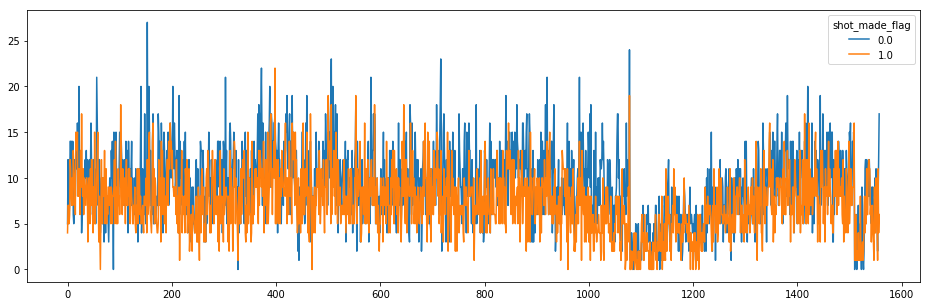

In [52]:
matplotlib.rcParams['figure.figsize'] = (16.0, 5.0)
data_count_pivot[[0.0,1.0]].plot()

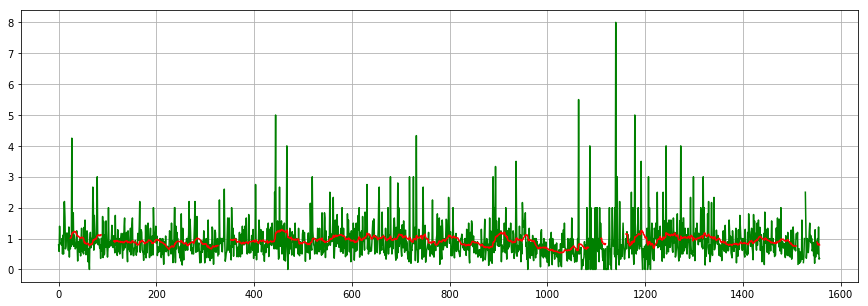

In [84]:
data_count_pivot['x'] = data_count_pivot[1.0]/data_count_pivot[0.0]
x_mean = data_count_pivot['x'].rolling(window=25).mean()
plt.figure(figsize=(15,5))
plt.plot(data_count_pivot['x'], "g", label="x")
plt.plot(x_mean,'r', label="x_mean")
plt.grid(True)

In [82]:
data_count_pivot[data_count_pivot['x'] == 0].head()

shot_made_flag,game_id,0.0,1.0,x
63,20001059,4.0,0.0,0.0
469,20600489,6.0,0.0,0.0
960,21200971,3.0,0.0,0.0
1070,21501104,8.0,0.0,0.0
1079,29600027,1.0,0.0,0.0


In [70]:
x_mean.shape

(1558,)

In [ ]:
# 2. Подготовить фичи для обучения модели

In [ ]:
# 3. Обучить линейную модель, Lasso, Ridge

In [ ]:
# 4. Сравнить результаты на тестовом наборе данных - сделать train_test_split 
#    в самом начале, подготовить переменные, сравнить результаты работы классификаторов 
#    (те же 3), метрика ROC AUC

In [ ]:
# 5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют
#    наибольшую часть дисперсии целевой переменной